In [19]:
%pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 59.2 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 75.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


In [2]:
# try:
#   # %tensorflow_version only exists in Colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass
# import tensorflow as tf

import tensorflow as tf
# You'll generate plots of attention in order to see what parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [ ]:
# Suppress TensorFlow warnings and messages, especially ROCm Fusion messages
import os
import sys
import logging

# Set TensorFlow logging level to suppress most messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0=DEBUG, 1=INFO, 2=WARNING, 3=ERROR

# Suppress GPU Fusion messages more aggressively
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Disable other TensorFlow logs
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# This should specifically target ROCm Fusion messages
os.environ['TF_ROCM_FUSION_ENABLE'] = '0'

# Create a custom filter for stderr to filter out specific messages
class MessageFilter:
    def __init__(self, forbidden_phrase):
        self.forbidden_phrase = forbidden_phrase
        self.original_stderr = sys.stderr
        
    def write(self, message):
        if self.forbidden_phrase not in message:
            self.original_stderr.write(message)
            
    def flush(self):
        self.original_stderr.flush()

# Filter out ROCm Fusion messages
sys.stderr = MessageFilter("ROCm Fusion")

2025-06-03 05:53:15.287098: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:756] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-03 05:53:19.458471: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:756] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-03 05:53:19.458552: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:756] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-03 05:53:19.464512: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:756] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-03 05:53:19.464611: I tensorflow/compiler/xla/stream_executo

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
  image_zip = tf.keras.utils.get_file(name_of_zip,
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip)+'/train2014/'
else:
  PATH = os.path.abspath('.')+'/train2014/'

In [6]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [7]:
len(train_captions), len(all_captions)

(30000, 414113)

In [8]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [9]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [10]:
# Get unique images
encode_train = sorted(set(img_name_vector))

In [11]:
# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

In [ ]:
import os
import logging

# Set TensorFlow logging to suppress most messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0=DEBUG, 1=INFO, 2=WARNING, 3=ERROR
# Suppress GPU Fusion messages
logging.getLogger('tensorflow').setLevel(logging.ERROR)
# Disable other TensorFlow logs
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
# Specifically disable ROCm Fusion
os.environ['TF_ROCM_FUSION_ENABLE'] = '0'

: 

In [13]:
from tqdm import tqdm

for img, path in tqdm(image_dataset):
  # encode pake InceptionV3,
  batch_features = image_features_extract_model(img)
  # embeddingnya di reshape, di flatten, biar bisa dipake ama attentionnya
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

: 

: 

In [ ]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [ ]:
train_seqs[0]

[3, 2, 351, 687, 2, 280, 5, 2, 84, 339, 4]

In [ ]:
tokenizer.word_index

{'<unk>': 1,
 'a': 2,
 '<start>': 3,
 '<end>': 4,
 'on': 5,
 'of': 6,
 'the': 7,
 'in': 8,
 'with': 9,
 'and': 10,
 'is': 11,
 'man': 12,
 'to': 13,
 'sitting': 14,
 'an': 15,
 'two': 16,
 'people': 17,
 'at': 18,
 'standing': 19,
 'are': 20,
 'white': 21,
 'next': 22,
 'woman': 23,
 'street': 24,
 'table': 25,
 'that': 26,
 'holding': 27,
 'some': 28,
 'large': 29,
 'it': 30,
 'person': 31,
 'down': 32,
 'top': 33,
 'up': 34,
 'group': 35,
 'field': 36,
 'small': 37,
 'his': 38,
 'plate': 39,
 'black': 40,
 'tennis': 41,
 'near': 42,
 'front': 43,
 'room': 44,
 'dog': 45,
 'young': 46,
 'riding': 47,
 'train': 48,
 'by': 49,
 'red': 50,
 'baseball': 51,
 'water': 52,
 'cat': 53,
 'playing': 54,
 'has': 55,
 'walking': 56,
 'sign': 57,
 'bathroom': 58,
 'while': 59,
 'blue': 60,
 'kitchen': 61,
 'bus': 62,
 'food': 63,
 'there': 64,
 'green': 65,
 'bed': 66,
 'parked': 67,
 'grass': 68,
 'pizza': 69,
 'looking': 70,
 'snow': 71,
 'other': 72,
 'ball': 73,
 'beach': 74,
 'side': 75,
 'f

In [ ]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
cap_vector[0]

array([  3,   2, 351, 687,   2, 280,   5,   2,  84, 339,   4,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
cap_vector[0].shape

(49,)

In [ ]:
max_length = len(cap_vector[0])
max_length

49

## Split the data into training and testing

In [ ]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [ ]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

## Create a tf.data dataset for training



 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [ ]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  # Make sure we're returning TensorFlow values, not Python values
  return tf.identity(loss), tf.identity(total_loss)

In [ ]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

NameError: name 'start_epoch' is not defined

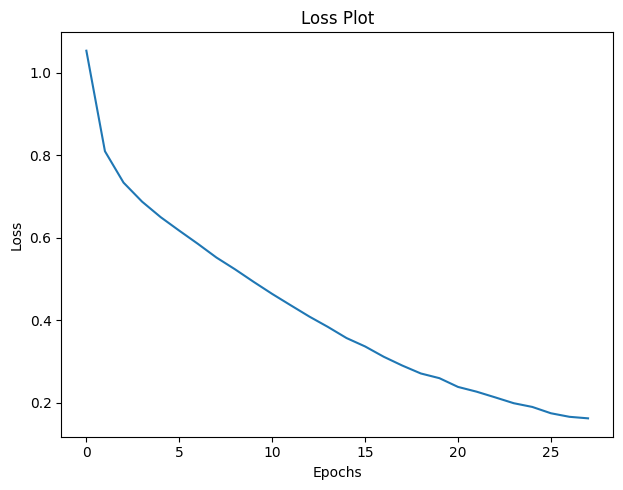

In [ ]:
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')


plt.tight_layout()
plt.show()

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a white toilet sitting under a bathroom window <end>
Prediction Caption: a bathroom with a counter space and white walls <end>


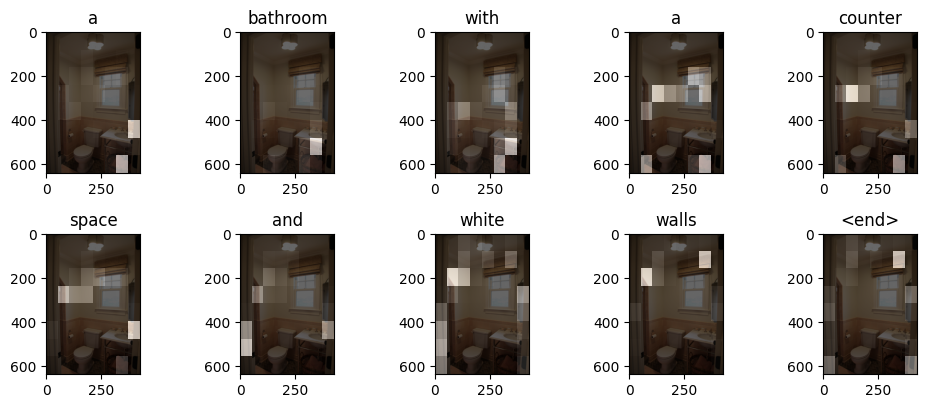

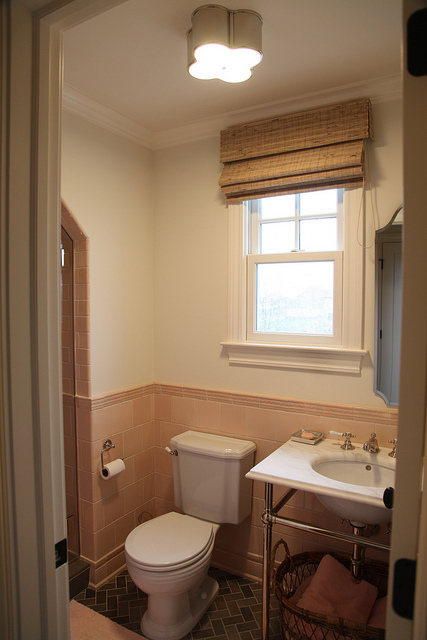

In [ ]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])

In [ ]:
image_url = 'https://oneacrefund.org/sites/default/files/styles/banner_large_desktop/public/2024-04/TZN_0819.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)
result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

NameError: name 'tf' is not defined

source:
    
https://www.tensorflow.org/tutorials/text/image_captioning

In [ ]:
def save_model(encoder, decoder, tokenizer, save_path="./saved_model"):
    """
    Save the image captioning model components for later use
    
    Args:
        encoder: The CNN encoder model
        decoder: The RNN decoder model
        tokenizer: The tokenizer used for captions
        save_path: Directory to save the model components
    """
    import os
    import pickle
    import json
    
    # Create the directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # 1. Save the encoder and decoder models
    encoder_path = os.path.join(save_path, "encoder")
    decoder_path = os.path.join(save_path, "decoder")
    
    tf.saved_model.save(encoder, encoder_path)
    tf.saved_model.save(decoder, decoder_path)
    print(f"Models saved to {save_path}")
    
    # 2. Save the tokenizer
    tokenizer_path = os.path.join(save_path, "tokenizer.pickle")
    with open(tokenizer_path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Tokenizer saved to {tokenizer_path}")
    
    # 3. Save configuration parameters
    config = {
        'max_length': max_length,
        'embedding_dim': embedding_dim,
        'units': units,
        'vocab_size': vocab_size,
        'attention_features_shape': attention_features_shape
    }
    
    config_path = os.path.join(save_path, "config.json")
    with open(config_path, 'w') as f:
        json.dump(config, f)
    print(f"Configuration saved to {config_path}")
    
    return save_path

# Function to load the model for inference
def load_model(load_path="./saved_model"):
    """
    Load the saved image captioning model components
    
    Args:
        load_path: Directory where model components are saved
        
    Returns:
        encoder: The CNN encoder model
        decoder: The RNN decoder model
        tokenizer: The tokenizer used for captions
        config: Dictionary containing configuration parameters
    """
    import os
    import pickle
    import json
    
    # 1. Load the encoder and decoder models
    encoder_path = os.path.join(load_path, "encoder")
    decoder_path = os.path.join(load_path, "decoder")
    
    encoder = tf.saved_model.load(encoder_path)
    decoder = tf.saved_model.load(decoder_path)
    print(f"Models loaded from {load_path}")
    
    # 2. Load the tokenizer
    tokenizer_path = os.path.join(load_path, "tokenizer.pickle")
    with open(tokenizer_path, 'rb') as handle:
        tokenizer = pickle.load(handle)
    print(f"Tokenizer loaded from {tokenizer_path}")
    
    # 3. Load configuration parameters
    config_path = os.path.join(load_path, "config.json")
    with open(config_path, 'r') as f:
        config = json.load(f)
    print(f"Configuration loaded from {config_path}")
    
    return encoder, decoder, tokenizer, config



In [ ]:
# Save our trained model
save_path = save_model(encoder, decoder, tokenizer, save_path="./final_model")
print(f"Model successfully saved to {save_path}")

Models saved to ./final_model
Tokenizer saved to ./final_model/tokenizer.pickle
Configuration saved to ./final_model/config.json
Model successfully saved to ./final_model


In [ ]:
def caption_image_with_saved_model(image_path, load_path="./final_model"):
    """
    Generate a caption for an image using the saved model
    
    Args:
        image_path: Path to the image to caption
        load_path: Directory where model components are saved
        
    Returns:
        result: List of words in the caption
        attention_plot: Attention weights for visualization
    """
    # Load the model components
    encoder, decoder, tokenizer, config = load_model(load_path)
    
    # Extract needed parameters from config
    max_length = config['max_length']
    attention_features_shape = config['attention_features_shape']
    
    # Initialize attention plot
    attention_plot = np.zeros((max_length, attention_features_shape))
    
    # Preprocess the image
    temp_input = tf.expand_dims(load_image(image_path)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    
    # Initialize decoder state
    hidden = decoder.reset_state(batch_size=1)
    
    # Get features from encoder
    features = encoder(img_tensor_val)
    
    # Initialize decoder input with start token
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    
    # Generate caption word by word
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        
        # Store attention weights
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
        # Get predicted word
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])
        
        # Break if end token is predicted
        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot
        
        # Use the predicted word as the next input
        dec_input = tf.expand_dims([predicted_id], 0)
    
    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
test_image_path = "0050-4-cropped.jpg"
result, attention_plot = caption_image_with_saved_model(test_image_path)
print("Generated Caption:", ' '.join(result))

Models loaded from ./final_model
Tokenizer loaded from ./final_model/tokenizer.pickle
Configuration loaded from ./final_model/config.json


AttributeError: '_UserObject' object has no attribute 'reset_state'